# Baseline SRCNN 

In [1]:
from data import DIV2K
train = DIV2K(scale=4, downgrade='bicubic', subset='train')
train_ds = train.dataset(batch_size=16, random_transform=True)

In [2]:
# Baseline srcnn

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Add, Conv2D, Input, Lambda, UpSampling2D
from tensorflow.keras.models import Model
import cv2
from tensorflow.keras.preprocessing.image import save_img
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

def srcnn():
    '''
    creates a srcnn model with post_sampling
    '''
    x_in = Input(shape=(None, None, 3))
    x = (x_in - DIV2K_RGB_MEAN) / 127.5 # normalize
    x = UpSampling2D(size=(4, 4), interpolation = 'bilinear')(x)
    
    x = Conv2D(64, 9, padding='same', activation='relu')(x)
    x = Conv2D(32, 5, padding='same', activation='relu')(x)
    x = Conv2D(3, 5, padding='same')(x)
    
    x = x * 127.5 + DIV2K_RGB_MEAN # denormalize
    return Model(x_in, x, name="srcnn")


In [3]:
model_base = srcnn()

In [4]:
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.python.keras.models import Model

# Adam optimizer with a scheduler that halfs learning rate after 20,000 steps
optim_srcnn = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[20000], values=[1e-4, 5e-5]))

# Compile and train model for 300,000 steps with L1 pixel loss
model_base.compile(optimizer=optim_srcnn, loss='mean_squared_error')
model_base.fit(train_ds, epochs=50, steps_per_epoch=1000)

# Save model weights
weights_dir = 'weights/'
model_base.save_weights(os.path.join(weights_dir, 'weights-srcnn-base-mse-x4.h5'))

Epoch 1/50
1000/1000 [==============================] - 444s 444ms/step - loss: 321.1915
Epoch 2/50
1000/1000 [==============================] - 448s 448ms/step - loss: 219.6913
Epoch 3/50
1000/1000 [==============================] - 449s 449ms/step - loss: 210.1602
Epoch 4/50
1000/1000 [==============================] - 453s 453ms/step - loss: 205.5659
Epoch 5/50
1000/1000 [==============================] - 438s 438ms/step - loss: 202.5994
Epoch 6/50
1000/1000 [==============================] - 447s 447ms/step - loss: 201.3035
Epoch 7/50
1000/1000 [==============================] - 449s 449ms/step - loss: 196.3010
Epoch 8/50
1000/1000 [==============================] - 448s 448ms/step - loss: 198.4535
Epoch 9/50
1000/1000 [==============================] - 436s 436ms/step - loss: 196.7230
Epoch 10/50
1000/1000 [==============================] - 441s 441ms/step - loss: 198.2500
Epoch 11/50
1000/1000 [==============================] - 449s 449ms/step - loss: 191.7254
Epoch 12/50
1000/10

# SRCNN with post-upsampling

In [17]:
from data import DIV2K
train = DIV2K(scale=4, downgrade='bicubic', subset='train')
train_ds = train.dataset(batch_size=16, random_transform=True)

In [18]:
# Baseline srcnn: pre-upsampling
# Test: 1. Learnable post-upsampling

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Add, Conv2D, Input, Lambda, UpSampling2D
from tensorflow.keras.models import Model
import cv2
from tensorflow.keras.preprocessing.image import save_img
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

def srcnn_ps():
    '''
    creates a srcnn model with post_sampling
    '''
    x_in = Input(shape=(None, None, 3))
    x = (x_in - DIV2K_RGB_MEAN) / 127.5 # normalize

    x = Conv2D(64, 9, padding='same', activation='relu')(x)
    x = Conv2D(32, 5, padding='same', activation='relu')(x)
    x = Conv2D(3, 5, padding='same')(x)
    
    x = Conv2D(64 * (2 ** 2), 3, padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) 
    x = Conv2D(3 * (2 ** 2), 3, padding='same')(x)
    x = tf.nn.depth_to_space(x, 2)    
    
    x = x * 127.5 + DIV2K_RGB_MEAN # denormalize
    return Model(x_in, x, name="srcnn")

def normalize(x):
    return (x - DIV2K_RGB_MEAN) / 127.5

def denormalize(x):
    return x * 127.5 + DIV2K_RGB_MEAN

def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

In [19]:
model_srcnn = srcnn_ps()

In [20]:
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.python.keras.models import Model

# Adam optimizer with a scheduler that halfs learning rate after 200,000 steps
optim_srcnn = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[200000], values=[1e-4, 5e-5]))

# Compile and train model for 300,000 steps with L1 pixel loss
model_srcnn.compile(optimizer=optim_srcnn, loss='mean_squared_error')
model_srcnn.fit(train_ds, epochs=50, steps_per_epoch=1000)

# Save model weights
weights_dir = 'weights/'
model_srcnn.save_weights(os.path.join(weights_dir, 'weights-srcnn-ps-mse-x4.h5'))

Epoch 1/50
1000/1000 [==============================] - 147s 147ms/step - loss: 765.9739
Epoch 2/50
1000/1000 [==============================] - 141s 141ms/step - loss: 328.3283
Epoch 3/50
1000/1000 [==============================] - 141s 141ms/step - loss: 273.9994
Epoch 4/50
1000/1000 [==============================] - 141s 141ms/step - loss: 250.4173
Epoch 5/50
1000/1000 [==============================] - 141s 141ms/step - loss: 233.6585
Epoch 6/50
1000/1000 [==============================] - 141s 141ms/step - loss: 222.6289
Epoch 7/50
1000/1000 [==============================] - 141s 141ms/step - loss: 221.5614
Epoch 8/50
1000/1000 [==============================] - 141s 141ms/step - loss: 218.4115
Epoch 9/50
1000/1000 [==============================] - 143s 143ms/step - loss: 214.5671
Epoch 10/50
1000/1000 [==============================] - 141s 141ms/step - loss: 213.5125
Epoch 11/50
1000/1000 [==============================] - 141s 141ms/step - loss: 209.1701
Epoch 12/50
1000/10

Text(0.5, 1.0, 'hr')

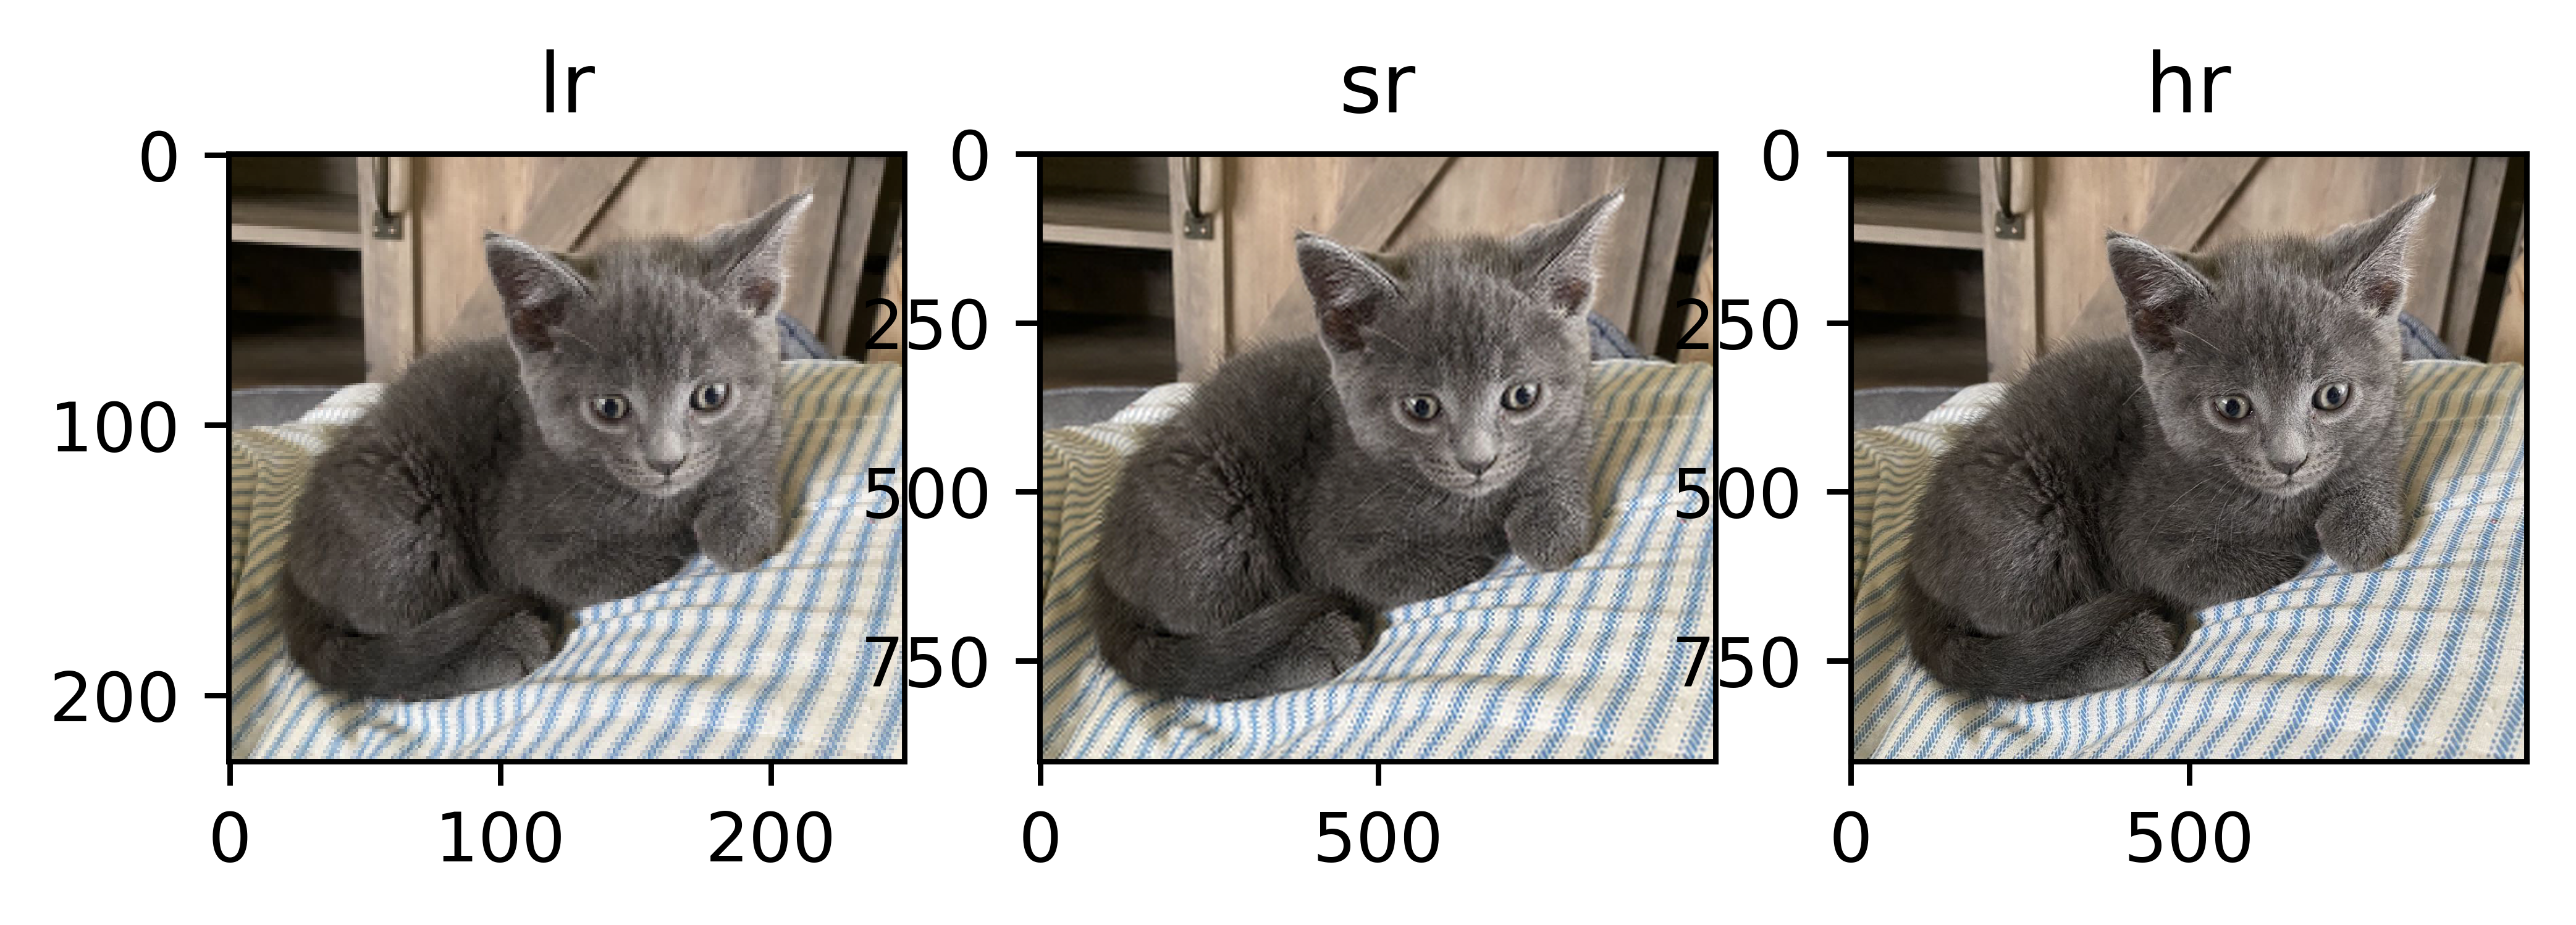

In [22]:
from utils import load_image
from matplotlib import pyplot as plt

import numpy as np
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from tensorflow.keras.preprocessing.image import save_img

def resolve_single(model, lr):
    return resolve(model, tf.expand_dims(lr, axis=0))[0]
def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch
#resolve_and_plot('demo/0851x4-crop.png')
hr = load_image('hr.jpg')[:,:,:3]
hr = rescale(hr,1,multichannel=True)
hr = hr[0:1000,200:1100,:]
hr = np.transpose(hr,(1,0,2))
#lr = rescale(hr,0.25,multichannel=True)
# lr = downscale_local_mean(hr,(4,4,1))
# lr = lr * 255

# save_img('lr.png',lr)

#lr = load_image('lr.png')

# sr_mse = resolve_single(model_srcnn, lr)
# plt.imshow(sr_mse)

# sr_mse = np.array(sr_mse)

# model_srcnn.load_weights(os.path.join(weights_dir, 'weights-srcnn-16-x4.h5'))
lr = load_image('lr.png')
sr = resolve_single(model_srcnn, lr)
fig,ax = plt.subplots(1,3,dpi=800)
ax[0].imshow(lr)
ax[0].set_title('lr')
ax[1].imshow(sr)
ax[1].set_title('sr')
ax[2].imshow(hr)
ax[2].set_title('hr')


# SRCNN with pre-upsampling

In [35]:
from data import DIV2K
train = DIV2K(scale=4, downgrade='bicubic', subset='train')
train_ds = train.dataset(batch_size=16, random_transform=True)

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Add, Conv2D, Input, Lambda, UpSampling2D
from tensorflow.keras.models import Model
import cv2
from tensorflow.keras.preprocessing.image import save_img
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

def srcnn_pres():
    '''
    creates a srcnn model with learnable pre_sampling
    '''
    x_in = Input(shape=(None, None, 3))
    x = (x_in - DIV2K_RGB_MEAN) / 127.5 # normalize

    x = Conv2D(64 * (2 ** 2), 3, padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) 
    x = Conv2D(64 * (2 ** 2), 3, padding='same')(x)
    x = tf.nn.depth_to_space(x, 2)   
    
    x = Conv2D(64, 9, padding='same', activation='relu')(x)
    x = Conv2D(32, 5, padding='same', activation='relu')(x)
    x = Conv2D(3, 5, padding='same')(x)
    
    x = x * 127.5 + DIV2K_RGB_MEAN # denormalize
    return Model(x_in, x, name="srcnn")

In [37]:
model_srcnn1 = srcnn_pres()

In [38]:
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.python.keras.models import Model

# Adam optimizer with a scheduler that halfs learning rate after 20,000 steps
optim_srcnn = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[20000], values=[1e-4, 5e-5]))

# Compile and train model for 300,000 steps with L1 pixel loss
model_srcnn1.compile(optimizer=optim_srcnn, loss='mean_squared_error')
model_srcnn1.fit(train_ds, epochs=50, steps_per_epoch=1000)

# Save model weights
weights_dir = 'weights/'
model_srcnn1.save_weights(os.path.join(weights_dir, 'weights-srcnn-pres-mse-x4.h5'))

Epoch 1/50
1000/1000 [==============================] - 146s 146ms/step - loss: 365.2186
Epoch 2/50
1000/1000 [==============================] - 145s 145ms/step - loss: 213.0912
Epoch 3/50
1000/1000 [==============================] - 142s 142ms/step - loss: 203.1930
Epoch 4/50
1000/1000 [==============================] - 142s 142ms/step - loss: 197.8603
Epoch 5/50
1000/1000 [==============================] - 142s 142ms/step - loss: 192.5589
Epoch 6/50
1000/1000 [==============================] - 142s 142ms/step - loss: 194.0134
Epoch 7/50
1000/1000 [==============================] - 142s 142ms/step - loss: 190.1692
Epoch 8/50
1000/1000 [==============================] - 142s 142ms/step - loss: 187.6598
Epoch 9/50
1000/1000 [==============================] - 142s 142ms/step - loss: 190.5687
Epoch 10/50
1000/1000 [==============================] - 142s 142ms/step - loss: 187.8042
Epoch 11/50
1000/1000 [==============================] - 141s 141ms/step - loss: 185.0841
Epoch 12/50
1000/10

# SRCNN with progressive upsampling

In [39]:
from data import DIV2K
train = DIV2K(scale=4, downgrade='bicubic', subset='train')
train_ds = train.dataset(batch_size=16, random_transform=True)

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Add, Conv2D, Input, Lambda, UpSampling2D
from tensorflow.keras.models import Model
import cv2
from tensorflow.keras.preprocessing.image import save_img
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

def srcnn_progs():
    '''
    creates a srcnn model with learnable progressive sampling
    '''
    x_in = Input(shape=(None, None, 3))
    x = (x_in - DIV2K_RGB_MEAN) / 127.5 # normalize
    
    x = Conv2D(64, 9, padding='same', activation='relu')(x)
    x = Conv2D(64 * (2 ** 2), 3, padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) 
    
    x = Conv2D(32, 5, padding='same', activation='relu')(x)
    x = Conv2D(64 * (2 ** 2), 3, padding='same')(x)
    x = tf.nn.depth_to_space(x, 2)   
    
    x = Conv2D(3, 5, padding='same')(x)
    
    x = x * 127.5 + DIV2K_RGB_MEAN # denormalize
    
    return Model(x_in, x, name="srcnn")

In [41]:
model_srcnn2 = srcnn_progs()

In [42]:
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.python.keras.models import Model

# Adam optimizer with a scheduler that halfs learning rate after 200,000 steps
optim_srcnn = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[20000], values=[1e-4, 5e-5]))

# Compile and train model for 300,000 steps with L1 pixel loss
model_srcnn2.compile(optimizer=optim_srcnn, loss='mean_squared_error')
model_srcnn2.fit(train_ds, epochs=50, steps_per_epoch=1000)

# Save model weights
weights_dir = 'weights/'
model_srcnn2.save_weights(os.path.join(weights_dir, 'weights-srcnn-progs-mse-x4.h5'))

Epoch 1/50
1000/1000 [==============================] - 140s 140ms/step - loss: 545.6767
Epoch 2/50
1000/1000 [==============================] - 140s 140ms/step - loss: 257.9256
Epoch 3/50
1000/1000 [==============================] - 140s 140ms/step - loss: 232.9001
Epoch 4/50
1000/1000 [==============================] - 140s 140ms/step - loss: 223.1944
Epoch 5/50
1000/1000 [==============================] - 140s 140ms/step - loss: 213.3934
Epoch 6/50
1000/1000 [==============================] - 140s 140ms/step - loss: 213.1079
Epoch 7/50
1000/1000 [==============================] - 140s 140ms/step - loss: 205.4578
Epoch 8/50
1000/1000 [==============================] - 140s 140ms/step - loss: 203.1044
Epoch 9/50
1000/1000 [==============================] - 140s 140ms/step - loss: 202.0212
Epoch 10/50
1000/1000 [==============================] - 140s 140ms/step - loss: 201.1046
Epoch 11/50
1000/1000 [==============================] - 140s 140ms/step - loss: 197.7536
Epoch 12/50
1000/10

# SRCNN with up and down upsampling

In [43]:
from data import DIV2K
train = DIV2K(scale=4, downgrade='bicubic', subset='train')
train_ds = train.dataset(batch_size=16, random_transform=True)

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Add, Conv2D, Input, Lambda, UpSampling2D, MaxPooling2D
from tensorflow.keras.models import Model
import cv2
from tensorflow.keras.preprocessing.image import save_img
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

def srcnn_iters():
    '''
    creates a srcnn model with learnable iterative sampling
    '''
    x_in = Input(shape=(None, None, 3))
    x = (x_in - DIV2K_RGB_MEAN) / 127.5 # normalize
    
    x = Conv2D(64, 9, padding='same', activation='relu')(x)
    x = Conv2D(64 * (2 ** 2), 3, padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) 
    x = MaxPooling2D()(x)
    
    
    x = Conv2D(32, 5, padding='same', activation='relu')(x)
    x = Conv2D(64 * (2 ** 2), 3, padding='same')(x)
    x = tf.nn.depth_to_space(x, 2)
    x = MaxPooling2D()(x)
    
    x = Conv2D(3, 5, padding='same')(x)
    
    x = Conv2D(64 * (2 ** 2), 3, padding='same')(x)
    x = tf.nn.depth_to_space(x, 2)     
    x = Conv2D(3 * (2 ** 2), 3, padding='same')(x)
    x = tf.nn.depth_to_space(x, 2)
    
    
    x = x * 127.5 + DIV2K_RGB_MEAN # denormalize
    
    return Model(x_in, x, name="srcnn")

In [45]:
model_srcnn3 = srcnn_iters()

In [46]:
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.python.keras.models import Model

# Adam optimizer with a scheduler that halfs learning rate after 200,000 steps
optim_srcnn = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[20000], values=[1e-4, 5e-5]))

# Compile and train model for 300,000 steps with L1 pixel loss
model_srcnn3.compile(optimizer=optim_srcnn, loss='mean_squared_error')
model_srcnn3.fit(train_ds, epochs=50, steps_per_epoch=1000)

# Save model weights
weights_dir = 'weights/'
model_srcnn3.save_weights(os.path.join(weights_dir, 'weights-srcnn-iters-mse-x4.h5'))

Epoch 1/50
1000/1000 [==============================] - 139s 139ms/step - loss: 836.1592
Epoch 2/50
1000/1000 [==============================] - 139s 139ms/step - loss: 352.4815
Epoch 3/50
1000/1000 [==============================] - 139s 139ms/step - loss: 285.6742
Epoch 4/50
1000/1000 [==============================] - 139s 139ms/step - loss: 255.0167
Epoch 5/50
1000/1000 [==============================] - 140s 140ms/step - loss: 237.8274
Epoch 6/50
1000/1000 [==============================] - 140s 140ms/step - loss: 231.8499
Epoch 7/50
1000/1000 [==============================] - 139s 139ms/step - loss: 224.2250
Epoch 8/50
1000/1000 [==============================] - 139s 139ms/step - loss: 216.8303
Epoch 9/50
1000/1000 [==============================] - 139s 139ms/step - loss: 214.3264
Epoch 10/50
1000/1000 [==============================] - 139s 139ms/step - loss: 210.6682
Epoch 11/50
1000/1000 [==============================] - 140s 140ms/step - loss: 212.1307
Epoch 12/50
1000/10